# Meta-analysis of COVID-19 papers

### Project for Management and Analysis of Physics Datasets
***

By: LamBHrusco gang



## Cluster setup

emmò la situa si complica

In [1]:
import pandas as pd
import numpy  as np 
import time
import matplotlib.pyplot as plt

In [2]:
client.close()

NameError: name 'client' is not defined

In [2]:
from dask.distributed import Client
#client = Client('localhost:8786')
client = Client()
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 3.84 GiB
Comm: tcp://127.0.0.1:32977,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 3.84 GiB
Comm: tcp://127.0.0.1:44171,Total threads: 1
Dashboard: http://127.0.0.1:44365/status,Memory: 3.84 GiB
Nanny: tcp://127.0.0.1:34831,


## Read of papers from JSON files

We will import JSON files and tranform them into Dask Bags

In [3]:
!head -n 4 COVID_papers/0000b93c66f991236db92dc16fa6db119b27ca12.json

{
    "paper_id": "0000b93c66f991236db92dc16fa6db119b27ca12",
    "metadata": {
        "title": "Infections in Hematopoietic Stem Cell Transplantation (HSCT) Patients 24",


In [4]:
#Read of the papers
! rm foo.bar
! ls COVID_papers >> foo.bar
#smaller dataset for various tests without the whole cluster
! rm foo2.bar
! ls COVID_papers_radio_edit >> foo2.bar

In [3]:
import dask.bag as db
import json
from urllib.request import urlopen

#b = db.read_text("foo.bar").map(lambda string: string.strip()).map(lambda string: "COVID_papers/"+string).map(open).map(json.load)
#b = db.read_text("https://raw.githubusercontent.com/Luca-Negri/Meta_Analysis_of_COVID_papers/main/foo.bar").map(lambda string: string.strip()).map(lambda string: "Meta_Analysis_of_COVID_papers/COVID_papers/"+string).map(open).map(json.load)

b = db.read_text("https://raw.githubusercontent.com/Luca-Negri/Meta_Analysis_of_COVID_papers/main/foo.bar").map(lambda string: string.strip()).map(lambda string: "COVID_papers/"+string).map(open).map(json.load)

#! rm dummy.mapd
#! ls COVID_papers >> dummy.mapd 
#with open('dummy.mapd') as file:
#    flist = ['https://raw.githubusercontent.com/Luca-Negri/Meta_Analysis_of_COVID_papers/main/COVID_papers/'+i.strip() for i in file]
#b = db.from_sequence(flist).map(urlopen).map(lambda x: x.read()).map(json.loads)

#b = b.repartition(len(flist))#select the number of partitions 
b

dask.bag<load, npartitions=1>

In [6]:
time1 = time.time()
print(b.take(20)[1]['body_text'][0]['text'])
print(time.time() - time1)

Se calcula que en España existen cerca de 367.000 plazas residenciales para personas mayores (PPMM) con una ocupación del 80%, con lo que casi 300.000 personas viven en ellas 1 . Respecto a sus características clínicas, el estudio de la Fundación Edad y Vida, sobre casi 20.000 personas, residentes en 111 centros de 15 CCAA 2 , las describe con una elevada pluripatología (76% de los casos tienen ≥3 diagnósticos activos) y polifarmacia (el 66% toman ≥7 fármacos), inestabilidad clínica (cada año el 38% son derivadas a urgencias) y terminalidad (el 43% fallecen durante el año). Al ingreso, 63% padecen deterioro cognitivo, 45% dependencia severa para las actividades básicas de la vida diaria, 55% malnutrición o riesgo de ella y 18% úlceras por presión. Perfiles similares han sido descritos en otros países 3 .
0.2748279571533203


In [4]:
def concatenate_text(paper_dict):
    
    """Function to tranform the body text field of the json files into a clean and usable 
        format, by concatenating the sections and removing unwanted characters
        
        
        Arguments:
        paper_dict ::: python dictionary containing the paper read from the JSON files
        
        
        Returns:
        paper_dict ::: now the "body_text" contains all the text sections concatenated
        
        
        """
    print('Concatenate!')
    body_text_list  = paper_dict['body_text'] #read of the text
    
    #concatenation of every section into one text file
    total_text = ''
    for text_section in body_text_list:
        total_text += text_section['text']
        
    total_text = total_text.lower()#lowercase everything
        
    # deteleting all unwanted characters
    
    
    forbidden_chars = ".,()[]:*><;°%/+"
    for forbidden_ch in forbidden_chars:
        
        total_text = total_text.replace(forbidden_ch,"")
        
    paper_dict['body_text'] = total_text
    
    return paper_dict
    
    
def word_count(paper_dict):
     
    """Function to count the occurencies of each word in the document using numpy functions
    
        Arguments:
        
        paper_dict ::: python dictionary containing the paper read from the JSON files
    
        
        Retrurns
        
        word_counts ::: python dictionary containing each word as key and the number of occurencies as value
    
    """
    
    import numpy as np # define right namespace
    print('io conto!')
    body_text = paper_dict['body_text']# get the text
    text_list = body_text.split() # transform into a list
    
    words, counts = np.unique(text_list, return_counts  = True) # count the words
    
    word_counts = {key : count for key,count in zip(words, counts)} # transform into a dictionary
    #paper_dict['word_count'] = word_counts # add dictionary  to json
    
    return word_counts
    
    
    

In [5]:
def reduce_counts(word_list1,word_list2):
    
    """Combines the results od two dictionaries"""
    
    print('io pure!')
    #obtaining the keys
    keys1 = word_list1.keys()
    keys2 = word_list2.keys()
    
    word_list_out = word_list1
    
    #add one value to the other
    for key2 in keys2:
            #check if already present
            if key2 not in keys1:
                word_list_out[key2] = word_list2[key2]
            else:
                word_list_out[key2] += word_list2[key2]
    return word_list_out
        
    
    

In [6]:
time1 = time.time()
b_conc  = b.map(concatenate_text).map(word_count)
b_conc.take(2)[1]
print(time.time() - time1)

1.1117579936981201


In [10]:
time1 = time.time()
b_conc  = b.map(concatenate_text).map(word_count)
b_count = b_conc.fold(reduce_counts)
oh = b_count.compute()
print(time.time() - time1)

Concatenate!
io conto!
Concatenate!
io conto!
Concatenate!
io conto!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Con

io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!
Concatenate!
io conto!
io pure!

16.824370861053467


In [11]:
oh_sort = dict(sorted(oh.items(), key=lambda item: item[1])[::-1])

words_related_to_research = ['et','al','fig','data','study','number','model','results'
                             ,'figure','p','t','reported','public','table','studies','higher'
                            ,'different','population','shown','period','analysis','information']

words_related_to_COVID    = ['mers-cov','covid-19','patients','infection',
                             'rate','health','cases','virus','disease','human','pandemic',
                            'viral','autophagy','growth','response','nodules','lockdown',
                            'contact','cells','care','case','positive','protein','stem','epidemic'
                            ,'transimission','dna']

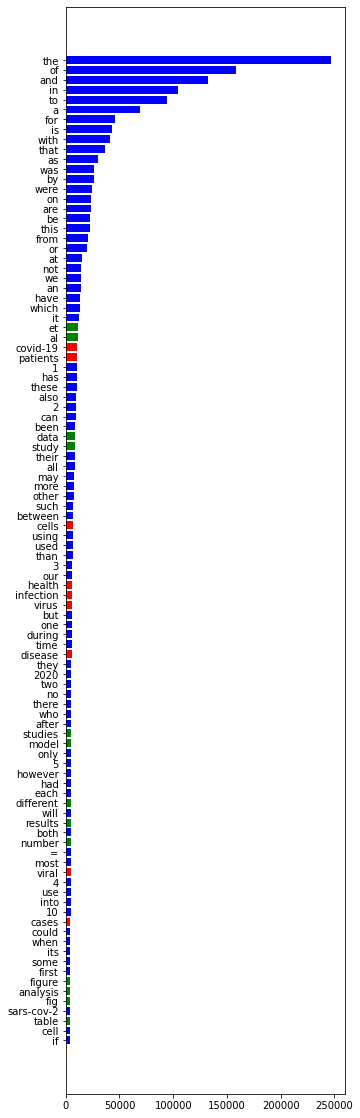

In [12]:
n_to_plot = 100
n_low = 0

list_of_vals = list(oh_sort.values())[n_low:n_to_plot]
list_of_keys = list(oh_sort.keys())[n_low:n_to_plot]

clist = []

for key in list_of_keys:
    
    if key in words_related_to_COVID:
        clist.append('red')
    elif key in words_related_to_research:
        clist.append('green')
    else:
        clist.append('blue')
    

plt.figure(figsize=[5,20])

plt.barh(list_of_keys[::-1],list_of_vals[::-1],color=clist[::-1])

#plt.xticks(rotation=60)

plt.show()

## Nations represented in research

We will now try to gather information on the research, from wich country it comes form

In [23]:
#b.take(4)[3]['metadata']#['authors']#[0]['affiliation']['location']['country']

def country_getter(paper_dict):
    
    authors = paper_dict['metadata']['authors']
    countries = {}
    for author in authors:
        try:
            
            country = author['affiliation']['location']['country']

                
        except:
            country = 'Not Available'
            
        if country not in countries.keys():
            country = country.replace(' Correspondence', '').replace(' Correspondencia', '').replace(';','').replace(':','')
            country = country.replace('. •', '').replace('.','').replace(' ²Our Research','').replace(' A B S T R A C T', '')
            c_list = country.split(', ')
            for c in c_list:
                if c not in countries.keys():
                    countries[c] = 1
                else:
                    countries[c] +=1
        else:
            countries[country]+=1
    
    return countries
        


In [24]:
countries = b.map(country_getter).fold(reduce_counts).compute()

io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
io pure!
i

In [55]:
for i in sorted(countries.keys(), key=lambda x:x.lower()):
    print(i)

4 Switzerland
7 Germany
Ann Arbor
Argentina
Australia
Austria
Austria *Correspondence
Bangladesh
Belgium
Brasil
Brazil
Brazil (
Brazil R
Cambodia
Canada
Chile
China
China (
Colombia
Croatia
Czech Republic
Denmark
Deutschland
Ecuador
Egypt
España
Estonia
Ethiopia
Finland
France
Georgia
Germany
Ghana
Gokhan
Greece
Guatemala
Hungary
India
Indonesia
Iran
Iran (the Islamic Republic of
Ireland
Israel
Italia
Italien
Italy
Japan
Japan (
Jordan
Kenya
Korea
Lithuania
Luxembourg
Malawi
Malaysia
Mauritius
Mexico
Mexico City
Morocco
Mozambique
Nepal
Netherlands
New Caledonia
New Zealand
Nigeria
Norway
Norwegen
Not Available
Oman
Osmaniye
P R China
Pakistan
People's Republic of China
Peru
Philippines
Poland
Portugal
PR China
Public Health England
Qatar
Republic of Korea
ROC
Romania
Russia
SA Avenida Italia
Saudi Arabia
Schweden
Scotland
Senegal
Serbia
Singapore
Slovakia
South Africa
South Korea
Spain
Spain 11
Spain Address
Spain email
Sweden
Switzerland
Syria
Taiwan
Tanzania
Thailand
the Netherlands

In [27]:
countries['P R China']

13

In [60]:
df     = pd.DataFrame(list(countries.items()),columns = ['Country','N_of_people'])
replacements     = {'PR China':'China',"People's Republic of China":'China','China (':'China','P R China':'China',
                    'ROC':'Taiwan',
                    'Mexico City':'Mexico',
                    'Japan (':'Japan',
                    'UK':'United Kingdom', 'UK)':'United Kingdom', 'Public Health England':'United Kingdom',
                    'UK A R':'United Kingdom','Scotland':'United Kingdom',
                    'Spain Address':'Spain', 'España':'Spain', 'Spain email':'Spain', 'Spain 11':'Spain',
                    '4 Switzerland':'Switzerland',
                    'U.S.A':'USA', 'United States of America':'USA', 'United States':'USA', 'The United States of America':'USA',
                    'UT':'USA', 'Ann Arbor':'USA', 'Unites States of America':'USA',
                    'Brasil':'Brazil', 'Brazil R':'Brazil', 'Brazil (':'Brazil',
                    'Österreich':'Austria', 'Austria *Correspondence':'Austria',
                    'Italien':'Italy', 'Italia':'Italy',
                    'Iran (the Islamic Republic of':'Iran',
                    'Osmaniye':'Turkey', 'Gokhan':'Turkey',
                    'the Netherlands':'The Netherlands', 'Netherlands':'The Netherlands',
                    'Korea':'South Korea', 'Republic of Korea':'South Korea',
                    'SA Avenida Italia':'Uruguay',
                    'Canada ²Our Research':'Canada',
                    'Valledupar Colombia':'Colombia',
                    'New Caledonia':'France',
                    'Schweden':'Sweden', 
                    'Norwegen':'Norway',
                    '7 Germany':'Germany', 'Deutschland':'Germany'
                    }

df     = df.replace(replacements)
df_new = df.groupby(by='Country',axis=0).sum()

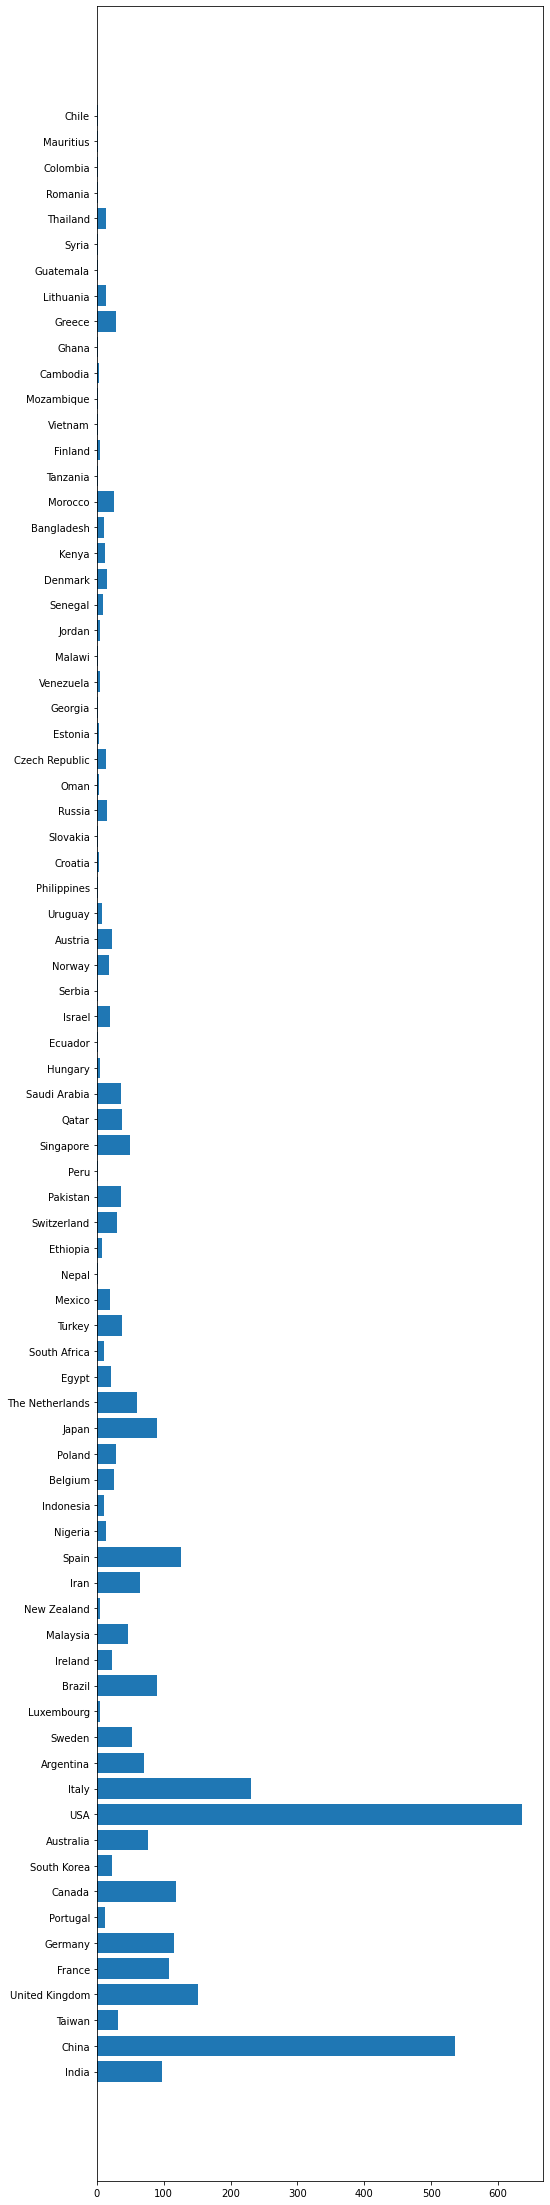

In [65]:
plt.figure(figsize=(8,40))
plt.barh(df[df['Country']!='Not Available']['Country'],df[df['Country']!='Not Available']['N_of_people'])
plt.show()

In [25]:
b.take(30)[-3]['metadata']

{'title': 'Middle East respiratory syndrome: An emerging coronavirus infection tracked by the crowd',
 'authors': [{'first': 'Ian',
   'middle': ['M'],
   'last': 'Mackay',
   'suffix': '',
   'affiliation': {'laboratory': 'Queensland Paediatric Infectious Diseases Laboratory',
    'institution': 'The University of Queensland',
    'location': {'settlement': 'Brisbane', 'country': 'Australia'}},
   'email': ''},
  {'first': 'Katherine',
   'middle': ['E'],
   'last': 'Arden',
   'suffix': '',
   'affiliation': {'laboratory': 'Queensland Paediatric Infectious Diseases Laboratory',
    'institution': 'The University of Queensland',
    'location': {'settlement': 'Brisbane', 'country': 'Australia'}},
   'email': ''}]}